In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.visualization import get_column_plot,set_plotly_config
import mlflow
from sdmetrics.single_table import BinaryAdaBoostClassifier, CategoricalCAP, CategoricalEnsemble, NumericalSVR
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

In [20]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
alembic                      1.13.1
aniso8601                    9.0.1
appdirs                      1.4.4
asttokens                    2.4.1
astunparse                   1.6.3
beautifulsoup4               4.12.2
blinker                      1.7.0
boto3                        1.33.5
botocore                     1.33.5
cachetools                   5.3.2
certifi                      2023.11.17
chardet                      5.2.0
charset-normalizer           3.3.2
click                        8.1.7
cloudpickle                  2.2.1
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.2.0
copulas                      0.9.2
ctgan                        0.9.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
deepecho                     0.5.0
docker                       7.0.0
e


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\20181588\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Load the dataset
dataset_path = 'Dataset/bar_pass_prediction.csv'
original_data = pd.read_csv(dataset_path)
# Make a copy of the dataset
data_full = original_data.copy()

TO DISCUSS: WE SHOULD AGREE TOGETHER ON WHICH COLUMNS WE WANT TO KEEP AND DO ALL FURTHER SDG MODELING WITH THE SAME COLUMNS

In [3]:
# List of columns to keep
columns_to_keep = [
    'pass_bar',  'ugpa', 'decile1', 'decile1b',
    'decile3', 'lsat', 'grad', 'fulltime', 'fam_inc',
    'tier', 'race1', 'gender'
]

# Convert 'grad' to binary where 'Y' is 1 and anything else is 0
data_full['grad'] = np.where(data_full['grad'] == 'Y', 1, 0)

df = data_full[columns_to_keep]

In [4]:
# Check how many rows with missing values are there
print(df.shape)
print(df.columns)
print(df.isnull().sum())
display(df.head())

(22407, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')
pass_bar       0
ugpa           0
decile1     1092
decile1b    1604
decile3     1604
lsat           0
grad           0
fulltime      34
fam_inc      289
tier          96
race1         16
gender         5
dtype: int64


,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,1,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,1,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,1,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,1,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,1,1.0,4.0,5.0,white,male


In [5]:
# Remove all rows with missing values
initial_row_count = df.shape[0]
df = df.dropna()
removed_rows = initial_row_count - df.shape[0]
print(f"Removed {removed_rows} rows with missing values.")

# Check df
print(df.shape)
print(df.columns)
print(df.isnull().sum())
display(df.head())

Removed 1895 rows with missing values.
(20512, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')
pass_bar    0
ugpa        0
decile1     0
decile1b    0
decile3     0
lsat        0
grad        0
fulltime    0
fam_inc     0
tier        0
race1       0
gender      0
dtype: int64


,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,1,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,1,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,1,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,1,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,1,1.0,4.0,5.0,white,male


In [6]:
# Check types of columns
print(df.dtypes)


pass_bar      int64
ugpa        float64
decile1     float64
decile1b    float64
decile3     float64
lsat        float64
grad          int32
fulltime    float64
fam_inc     float64
tier        float64
race1        object
gender       object
dtype: object


In [7]:
# Which colums are categorical
categorical_columns = df.select_dtypes(include=['object'])
print(categorical_columns.columns)

Index(['race1', 'gender'], dtype='object')


In [8]:
numerical_columns = [ 'pass_bar',  'ugpa', 'decile1', 'decile1b',
                      'decile3', 'lsat', 'grad', 'fulltime', 'fam_inc',
                      'tier'] #for now treat ordinal catagorical variables as numerical

categorical_columns = ['race1', 'gender']

REMARK: Columns: fulltime, dam_income, tier, pass_bar, grad are ordinal categorical variable

TO DISCUSS: Is it acceptable to treat them as numerical columns in general? Do we maybe want to hot encode them? Certain SDG models might deal better with ordinal categorical variables than others. Which test would be appropriate to assess quality of synthetic data bearing inmind we have a few categorical, a lot ordinal catagorical and a few numerical columns?

Be aware that including ordinal categorical variables in a correlation heatmap, like the one you're generating with Seaborn's heatmap function, can be appropriate if the ordinal variables are encoded numerically in a way that reflects their order. This is because correlation calculations require numerical input, and ordinal variables can be thought of as numeric in terms of their ranking or ordering.

Alternative Statistics: If you're concerned about the limitations of using Pearson's correlation with ordinal data, consider using alternative statistics that are designed for ordinal data, such as Spearman's rank correlation coefficient, which is based on the ranks of the data rather than their raw values and can be a better choice for ordinal data. Which other tests???

Generate Synthetic Data

In [9]:
# This modified function creates synthetic bootstrap samples from the original dataset, 
# including both numerical and categorical columns.

def create_bootstrap_samples(df, sample_size=None, n_samples=1000):
    """
    Creates synthetic bootstrap samples from the original dataset, including both
    numerical and categorical columns.

    Args:
        df: A pandas DataFrame containing the data.
        sample_size: The desired size of each bootstrap sample (default: original data size).
        n_samples: The number of bootstrap samples to generate (default: 1000).

    Returns:
        A pandas DataFrame containing all bootstrap samples concatenated together.
    """
    # If sample_size is not provided, use the length of the DataFrame
    if sample_size is None:
        sample_size = len(df)

    # Create a DataFrame to store bootstrap samples
    bootstrapped_df = pd.DataFrame()

    # Loop n_samples times to generate bootstrap samples
    for _ in range(n_samples):
        # Create a bootstrap sample of sample_size with replacement
        bootstrap_sample = df.sample(n=sample_size, replace=True)
        # Concatenate the bootstrap sample to the DataFrame
        bootstrapped_df = pd.concat([bootstrapped_df, bootstrap_sample])

    # Reset index to avoid duplicate indices from concatenation
    bootstrapped_df.reset_index(drop=True, inplace=True)

    # Return the concatenated DataFrame of bootstrap samples
    return bootstrapped_df

bootstrapped_df = create_bootstrap_samples(df) #runtime 7-8min for n_samples = 1000


In [11]:
# Check bootstrapped_df
print(bootstrapped_df.shape)
print(bootstrapped_df.columns)
print(bootstrapped_df.isnull().sum())
bootstrapped_df.head()

(20512000, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')
pass_bar    0
ugpa        0
decile1     0
decile1b    0
decile3     0
lsat        0
grad        0
fulltime    0
fam_inc     0
tier        0
race1       0
gender      0
dtype: int64


,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.9,7.0,7.0,8.0,40.0,1,1.0,3.0,4.0,white,male
1,1,3.3,2.0,2.0,5.0,39.0,1,1.0,5.0,6.0,asian,female
2,1,3.0,2.0,2.0,3.0,31.0,1,1.0,3.0,3.0,white,female
3,1,3.1,6.0,6.0,7.0,37.0,1,1.0,4.0,3.0,white,female
4,1,3.4,9.0,9.0,7.0,39.0,1,1.0,3.0,4.0,white,male


In [12]:
# Check df
print(df.shape)
print(df.columns)
print(df.isnull().sum())
df.head()

(20512, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')
pass_bar    0
ugpa        0
decile1     0
decile1b    0
decile3     0
lsat        0
grad        0
fulltime    0
fam_inc     0
tier        0
race1       0
gender      0
dtype: int64


,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,1,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,1,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,1,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,1,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,1,1.0,4.0,5.0,white,male


TO DISCUSS: WHICH TESTS DO WE RUN TO COMPARE QUALITY OF BOOTSTRAPPED SYNTHETIC DATA WITH GAUSSIAN COUPOLA SYNTHETIC DATA? SHALL WE RESEARCH THIS FOR NEXT WEEK?

Evaluate Synthetic Data

In [13]:
from scipy.stats import ks_2samp, chi2_contingency

def evaluate_bootstrapped_data(original_data, bootstrapped_data, numerical_columns, categorical_columns):
    """
    Evaluates the bootstrapped data by comparing it to the original data,
    including both numerical and categorical columns.
  
    Args:
        original_data: A pandas DataFrame containing the original data.
        bootstrapped_data: A pandas DataFrame containing the bootstrapped data.
        numerical_columns: A list of names of numerical columns to evaluate.
        categorical_columns: A list of names of categorical columns to evaluate.
  
    Returns:
        A dictionary containing the evaluation results for each metric.
    """
    evaluation_results = {'numerical': {}, 'categorical': {}}

    # Evaluate numerical columns
    for column in numerical_columns:
        original_column_data = original_data[column]
        bootstrapped_column_data = bootstrapped_data[column]

        # Perform a Kolmogorov-Smirnov test
        ks_statistic, ks_pvalue = ks_2samp(original_column_data, bootstrapped_column_data)

        evaluation_results['numerical'][column] = {
            'original_mean': original_column_data.mean(),
            'bootstrapped_mean': bootstrapped_column_data.mean(),
            'original_std': original_column_data.std(),
            'bootstrapped_std': bootstrapped_column_data.std(),
            'ks_statistic': ks_statistic,
            'ks_pvalue': ks_pvalue
        }

    # Evaluate categorical columns
    for column in categorical_columns:
        original_counts = original_data[column].value_counts(normalize=True)
        bootstrapped_counts = bootstrapped_data[column].value_counts(normalize=True)

        # Perform a Chi-squared test for distribution of categorical variables
        contingency_table = pd.concat([original_counts, bootstrapped_counts], axis=1).fillna(0)
        chi2_statistic, chi2_pvalue, _, _ = chi2_contingency(contingency_table)

        evaluation_results['categorical'][column] = {
            'original_proportions': original_counts.to_dict(),
            'bootstrapped_proportions': bootstrapped_counts.to_dict(),
            'chi2_statistic': chi2_statistic,
            'chi2_pvalue': chi2_pvalue
        }

    # Evaluate correlations
    original_corr = original_data[numerical_columns].corr()
    bootstrapped_corr = bootstrapped_data[numerical_columns].corr()
    corr_diff = (bootstrapped_corr - original_corr).abs().sum().sum() / (len(numerical_columns) ** 2)

    evaluation_results['correlation_difference'] = corr_diff

    return evaluation_results


In [14]:
evaluation_results = evaluate_bootstrapped_data(df, bootstrapped_df, numerical_columns, categorical_columns)

In [15]:
def print_evaluation_results(evaluation_results):
    """
    Prints the evaluation results in a readable format.

    Args:
        evaluation_results: A dictionary containing the evaluation results for each metric.
    """

    # Print numerical evaluation results
    print("Numerical Columns Evaluation:\n")
    for column, metrics in evaluation_results['numerical'].items():
        print(f"--- {column} ---")
        print(f"Original Mean: {metrics['original_mean']:.2f}")
        print(f"Bootstrapped Mean: {metrics['bootstrapped_mean']:.2f}")
        print(f"Original Std Dev: {metrics['original_std']:.2f}")
        print(f"Bootstrapped Std Dev: {metrics['bootstrapped_std']:.2f}")
        print(f"KS Statistic: {metrics['ks_statistic']:.4f}")
        print(f"KS P-Value: {metrics['ks_pvalue']:.4f}")
        print("")

    # Print categorical evaluation results
    print("Categorical Columns Evaluation:\n")
    for column, metrics in evaluation_results['categorical'].items():
        print(f"--- {column} ---")
        print(f"Original Proportions: {metrics['original_proportions']}")
        print(f"Bootstrapped Proportions: {metrics['bootstrapped_proportions']}")
        print(f"Chi2 Statistic: {metrics['chi2_statistic']:.4f}")
        print(f"Chi2 P-Value: {metrics['chi2_pvalue']:.4f}")
        print("")

    # Print correlation evaluation result
    print("Correlation Structure Evaluation:")
    print(f"Total Absolute Difference in Correlation: {evaluation_results['correlation_difference']:.4f}")
    print("")

# Example usage
print_evaluation_results(evaluation_results)


Numerical Columns Evaluation:

--- pass_bar ---
Original Mean: 0.95
Bootstrapped Mean: 0.95
Original Std Dev: 0.22
Bootstrapped Std Dev: 0.22
KS Statistic: 0.0001
KS P-Value: 1.0000

--- ugpa ---
Original Mean: 3.21
Bootstrapped Mean: 3.21
Original Std Dev: 0.40
Bootstrapped Std Dev: 0.40
KS Statistic: 0.0001
KS P-Value: 1.0000

--- decile1 ---
Original Mean: 5.72
Bootstrapped Mean: 5.72
Original Std Dev: 2.78
Bootstrapped Std Dev: 2.78
KS Statistic: 0.0002
KS P-Value: 1.0000

--- decile1b ---
Original Mean: 5.53
Bootstrapped Mean: 5.53
Original Std Dev: 2.85
Bootstrapped Std Dev: 2.85
KS Statistic: 0.0002
KS P-Value: 1.0000

--- decile3 ---
Original Mean: 5.53
Bootstrapped Mean: 5.53
Original Std Dev: 2.85
Bootstrapped Std Dev: 2.85
KS Statistic: 0.0002
KS P-Value: 1.0000

--- lsat ---
Original Mean: 36.71
Bootstrapped Mean: 36.71
Original Std Dev: 5.38
Bootstrapped Std Dev: 5.38
KS Statistic: 0.0002
KS P-Value: 1.0000

--- grad ---
Original Mean: 1.00
Bootstrapped Mean: 1.00
Original


Similarity of Means and Standard Deviations: Since the means and standard deviations of the bootstrapped data are similar to those of the original data, it appears that the bootstrapping process did a good job of preserving the individual characteristics of each numerical variable.

Distributional Similarity: The KS test results suggest that not only are the central tendency and dispersion preserved, but also the shapes of the distributions, since the distributions of the bootstrapped data are not significantly different from the original data.

Preservation of Categorical Distributions: The categorical variables' distributions are also preserved in the bootstrapped data, as indicated by the Chi-Squared test.

Correlation Preservation: The bootstrapped data maintains the correlation structure of the original data, which is crucial when the relationships between variables are important for analysis or modeling.

Based on these results, we can infer that the bootstrapped data is of high quality in terms of being representative of the original data. The bootstrapping process successfully preserved the univariate properties of both numerical and categorical variables, as well as the multivariate properties in terms of correlations.

It's important to reiterate that bootstrapping is not typically used for creating synthetic datasets for privacy-preserving purposes, especially when the original data contains many unique rows. It's mainly used for estimating the sampling distribution of a statistic. For synthetic data generation, more advanced techniques like those provided by synthetic data generation libraries or differential privacy should be considered.

Bootstrap Limitation: Bootstrapping by nature will create samples that are statistically similar to the original dataset because it's simply re-sampling from the original data. Some rows will be duplicated, but each sample is essentially composed of rows from the original dataset.

Privacy Concerns: Even though bootstrapped data doesn't correspond to the original rows one-to-one, there is still a risk that individuals could be identified, especially if there are unique or rare combinations of attributes in the data.

To address these concerns and to ensure the synthetic data cannot be directly traced back to individuals in the original dataset, you can consider:

Differential Privacy: Introduce noise into the data to ensure privacy. This might reduce the utility of the data somewhat, but it also provides a stronger privacy guarantee.

Other Synthetic Data Techniques: Instead of simple bootstrapping, use more advanced synthetic data generation techniques, such as generative adversarial networks (GANs) or variational autoencoders (VAEs), which learn the distributions of the original data and generate new, synthetic data points.

In [16]:
# Check to compare the uniqueness of rows between the original and bootstrapped data

original_unique_rows = len(df.drop_duplicates())
bootstrapped_unique_rows = len(create_bootstrap_samples(df).drop_duplicates())

print(f'Original unique rows: {original_unique_rows}')
print(f'Bootstrapped unique rows: {bootstrapped_unique_rows}')


Original unique rows: 19940
Bootstrapped unique rows: 19940


Evaluation plots

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

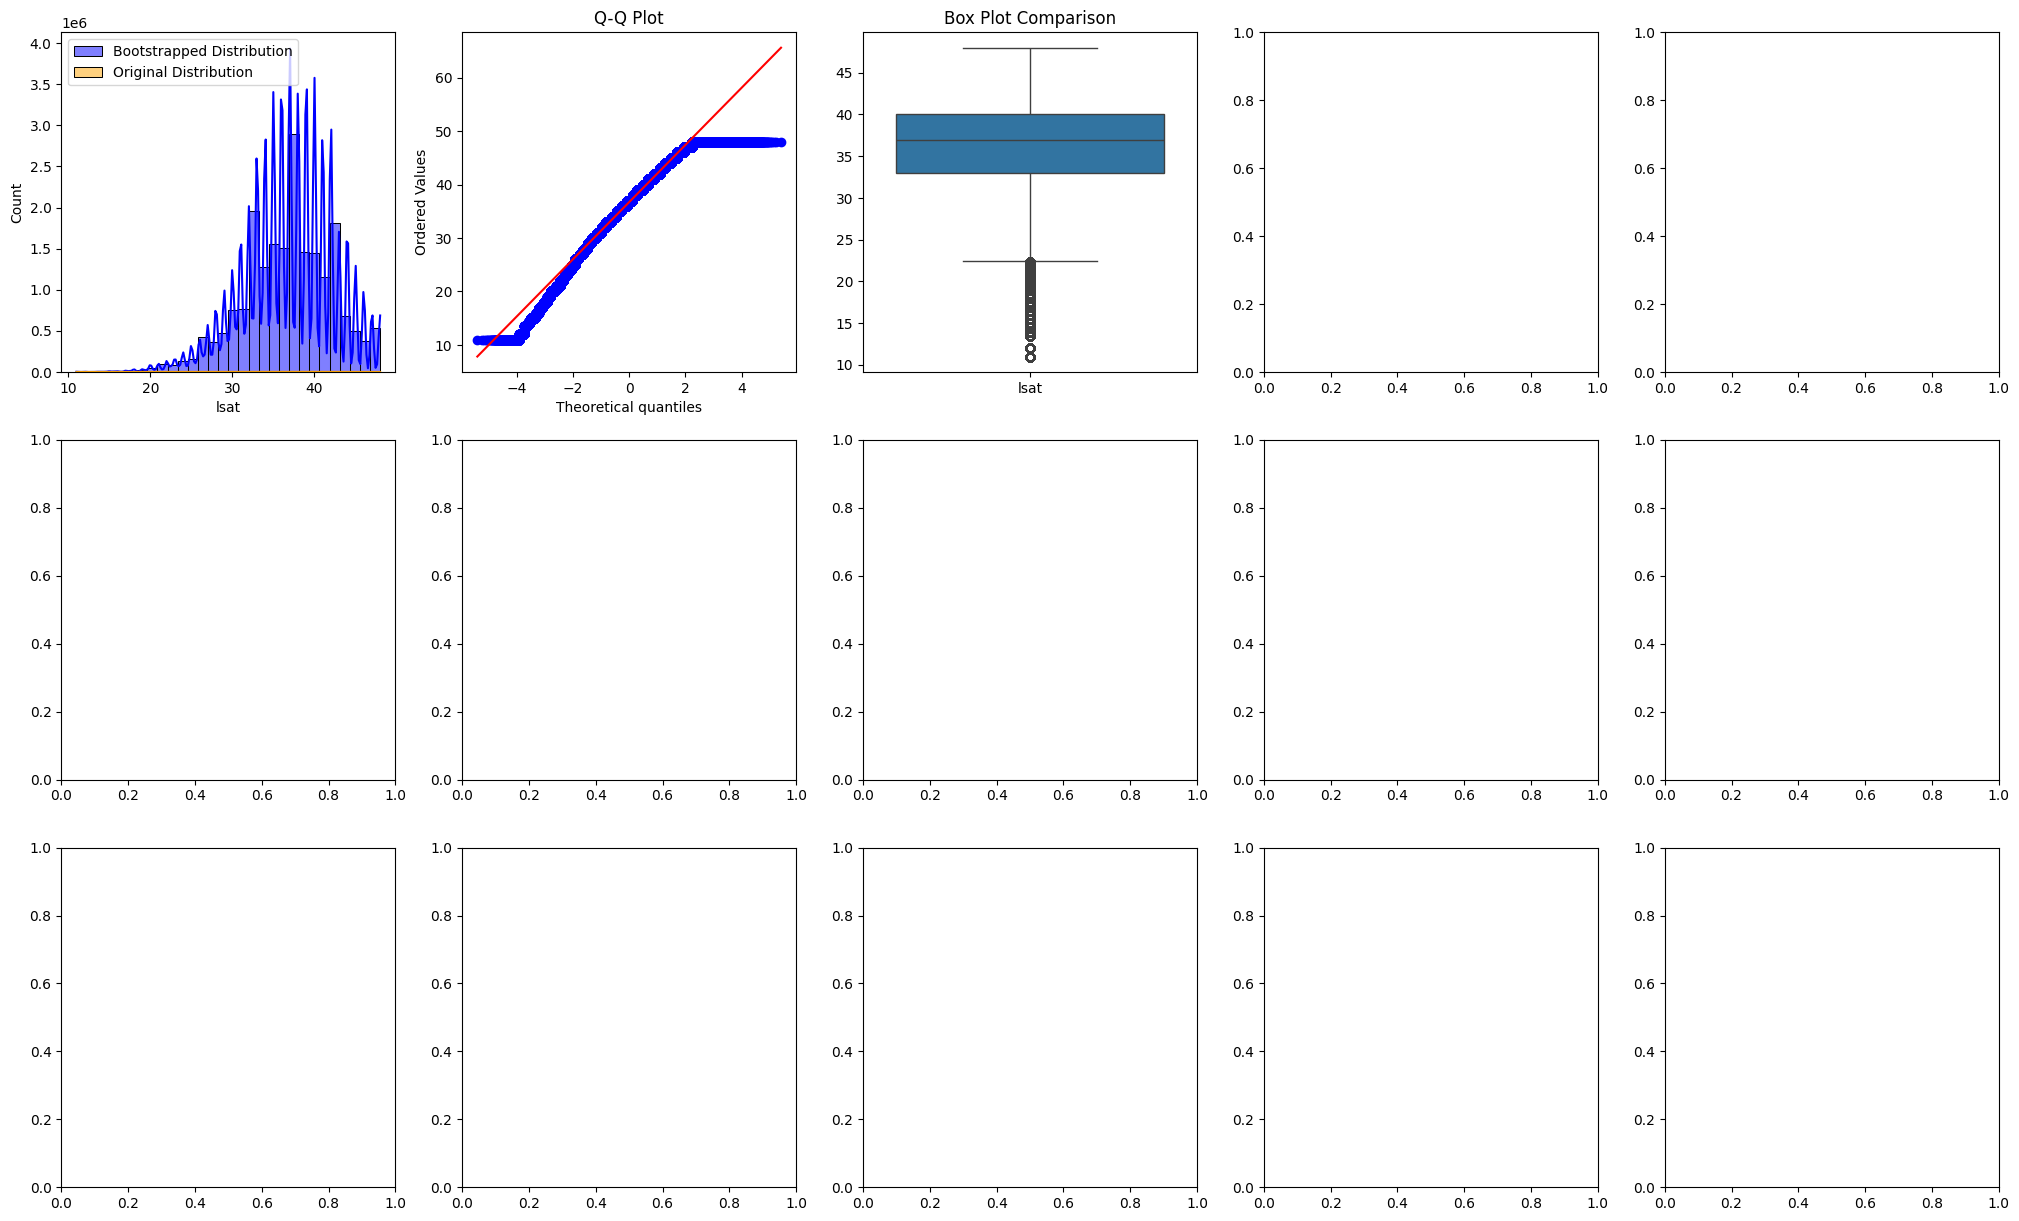

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd

def plot_data_and_bootstrapped(df, bootstrapped_data, numerical_columns):
    if not all(col in df.columns for col in numerical_columns):
        missing_cols = [col for col in numerical_columns if col not in df.columns]
        raise ValueError(f"Missing columns in the dataframe: {missing_cols}")

    num_plots = len(numerical_columns)
    fig, axes = plt.subplots(num_plots, 5, figsize=(25, 5 * num_plots))

    for i, column in enumerate(numerical_columns):
        original_data = df[column].dropna()
        bootstrap_data = bootstrapped_data[column].dropna()

        # Distribution comparison and Confidence Interval
        ax = axes[i, 0]
        sns.histplot(bootstrap_data, kde=True, bins=30, ax=ax, color='blue', label='Bootstrapped Distribution')
        sns.histplot(original_data, kde=True, bins=30, ax=ax, color='orange', alpha=0.5, label='Original Distribution')
        ax.legend()

        # Q-Q Plot
        ax = axes[i, 1]
        stats.probplot(bootstrap_data, dist="norm", plot=ax)
        ax.set_title('Q-Q Plot')

        # Box Plot
        ax = axes[i, 2]
        sns.boxplot(data=[original_data, bootstrap_data], ax=ax)
        ax.set_title('Box Plot Comparison')

        # Bland-Altman Plot
        ax = axes[i, 3]
        mean = np.mean([original_data, bootstrap_data], axis=0)
        diff = original_data - bootstrap_data    # Difference between data
        md = np.mean(diff)                       # Mean of the difference
        sd = np.std(diff, axis=0)                # Standard deviation of the difference
        ax.scatter(mean, diff)
        ax.axhline(md, color='gray', linestyle='--')
        ax.axhline(md + 1.96 * sd, color='red', linestyle='--')
        ax.axhline(md - 1.96 * sd, color='red', linestyle='--')
        ax.set_title('Bland-Altman Plot')

        # Kolmogorov-Smirnov Test
        ax = axes[i, 4]
        ks_stat, ks_p = stats.ks_2samp(original_data, bootstrap_data)
        ax.text(0.1, 0.8, f'KS Statistic: {ks_stat:.3f}\np-value: {ks_p:.3g}', transform=ax.transAxes)
        ax.axis('off')
        ax.set_title('K-S Test Results')

    fig.tight_layout()
    plt.show()

# Ensure you replace 'Column1', 'Column2', 'Column3' with actual column names you want to evaluate
plot_data_and_bootstrapped(df, bootstrapped_df, ['lsat', 'fam_inc', 'tier'])
